#Sentiment Analysis

In this part, we will perform sentiment analysis on user comments from **Snappfood**, an online food delivery company. The dataset consists of 70,000 comments with two labels: "1" for "Happy" and "0 for""Sad." Our goal is to build a text classification model using BERT and ParsBERT to automatically classify user comments based on their sentiment.

In [1]:
model_name_bert = "bert-base-uncased"
model_name_parsbert = "HooshvareLab/bert-base-parsbert-uncased"

[Train Dataset](https://drive.google.com/file/d/11ejNp1oow2Xz6xCWggzwcz1KeqEH_zwI/view?usp=sharing)


[Validation Dataset](https://drive.google.com/file/d/1d19ZtsKE_gfUdreu9aO5ia6crUVo0xPW/view?usp=sharing)




You can see the below picture for the classification architecture using BERT.

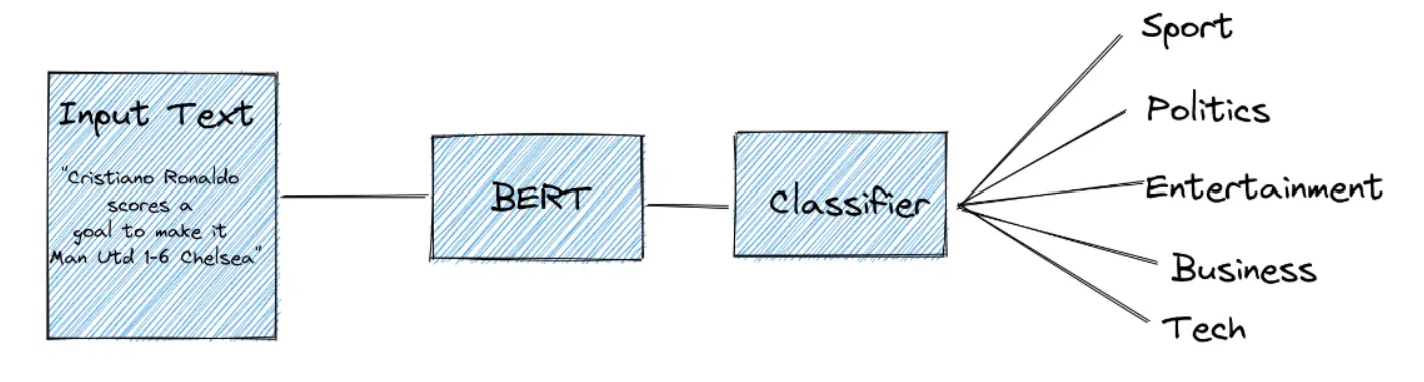

##A) Dataset

### Import Modules/Libraries



In [2]:
!pip install -U -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
!pip install -q datasets evaluate gdown pandas scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import torch
import gdown
import os

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import evaluate

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Downloading...
From: https://drive.google.com/uc?id=11ejNp1oow2Xz6xCWggzwcz1KeqEH_zwI
To: /content/snappfood_train.csv
100%|██████████| 1.19M/1.19M [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d19ZtsKE_gfUdreu9aO5ia6crUVo0xPW
To: /content/snappfood_val.csv
100%|██████████| 1.07M/1.07M [00:00<00:00, 96.5MB/s]

--- Training Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7000 non-null   int64 
 1   comment     7000 non-null   object
 2   label       7000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 164.2+ KB
None

First 5 rows of training data:


,Unnamed: 0,comment,label
0,0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,1
1,1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,1
2,2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,0
3,3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,0
4,4,باز هم میگم، پیتزا نباید اینقد چرب باشه,0



--- Validation Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6300 non-null   int64 
 1   comment     6300 non-null   object
 2   label       6300 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 147.8+ KB
None

First 5 rows of validation data:


,Unnamed: 0,comment,label
0,0,همه ساندویچ‌ها سرد بود متاسفانه در صورتی که فا...,0
1,1,تشکر، عالی‌تر از همیشه,1
2,2,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...,1
3,3,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد؟؟؟,0
4,4,یک نوشابه کم ارسال شد و تاخیر فراوان و غذای نس...,0



--- Class Distribution in Training Set ---
label
1    3500
0    3500
Name: count, dtype: int64

The dataset is reasonably balanced.


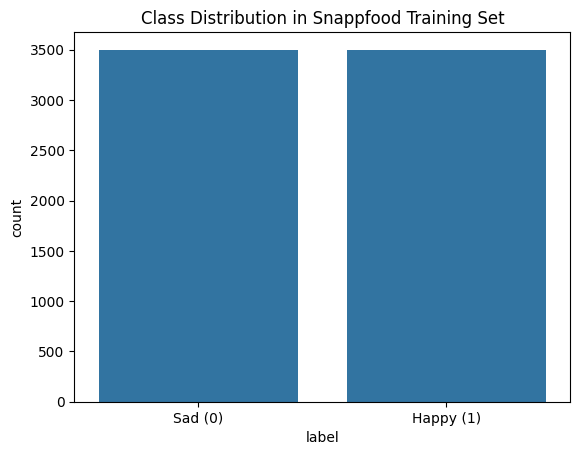


--- Hugging Face Dataset Object ---
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'comment', 'label'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'comment', 'label'],
        num_rows: 6300
    })
})


In [ ]:
train_file_id = '11ejNp1oow2Xz6xCWggzwcz1KeqEH_zwI'
val_file_id = '1d19ZtsKE_gfUdreu9aO5ia6crUVo0xPW'
train_path = 'snappfood_train.csv'
val_path = 'snappfood_val.csv'

gdown.download(id=train_file_id, output=train_path, quiet=False)
gdown.download(id=val_file_id, output=val_path, quiet=False)

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

print("--- Training Data ---")
print(df_train.info())
print("\nFirst 5 rows of training data:")
display(df_train.head())

print("\n--- Validation Data ---")
print(df_val.info())
print("\nFirst 5 rows of validation data:")
display(df_val.head())


print("\n--- Class Distribution in Training Set ---")
class_balance = df_train['label'].value_counts()
print(class_balance)
if abs(class_balance[0] - class_balance[1]) / len(df_train) < 0.1:
    print("\nThe dataset is reasonably balanced.")
else:
    print("\nThe dataset is imbalanced.")

sns.countplot(x='label', data=df_train)
plt.title('Class Distribution in Snappfood Training Set')
plt.xticks([0, 1], ['Sad (0)', 'Happy (1)'])
plt.show()


train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

print("\n--- Hugging Face Dataset Object ---")
print(raw_datasets)

##2) Preprocessing


**Tokenization** is an essential step in natural language processing (NLP) where text data is converted into numerical arrays using vocabulary mapping.

- There are various tokenization methods, including word-based, character-based, and sub-word based tokenization.

HuggingFace's AutoTokenizer class is a popular choice for tokenization, utilizing pre-trained tokenizers from different models.

It is crucial to ensure that the tokenizer and model checkpoint are compatible for consistent tokenization. For example, when fine-tuning the ParsBert model on the snapfood dataset, the tokenizer and model weights can be accessed through the HuggingFace library using the model name.

 Importing the tokenizer can be done with the AutoTokenizer module.

HuggingFace will automatically download and cache the tokeniser locally. Now let's see how the tokeniser works with an example,

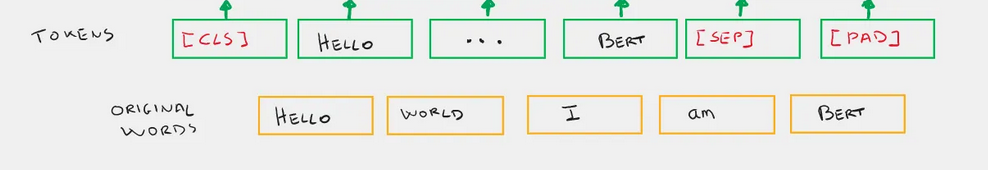

In [ ]:
parsbert_tokenizer = AutoTokenizer.from_pretrained(model_name_parsbert)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name_bert)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 🔶 Print Tokenized output, Tokenized tokens and Tokenized text for the text below.

In [ ]:
text = "یه کم خشک بود ولی در مجموع خوشمزه بود"


print("--- Tokenization with ParsBERT ---")
parsbert_tokenized_output = parsbert_tokenizer(text)
print("Tokenized Output (IDs):", parsbert_tokenized_output)

tokens = parsbert_tokenizer.convert_ids_to_tokens(parsbert_tokenized_output['input_ids'])
print("Tokens:", tokens)

decoded_text = parsbert_tokenizer.decode(parsbert_tokenized_output['input_ids'])
print("Decoded Text:", decoded_text)

print("\n--- Tokenization with BERT-base-uncased ---")
bert_tokenized_output = bert_tokenizer(text)
print("Tokenized Output (IDs):", bert_tokenized_output)

tokens = bert_tokenizer.convert_ids_to_tokens(bert_tokenized_output['input_ids'])
print("Tokens:", tokens)

decoded_text = bert_tokenizer.decode(bert_tokenized_output['input_ids'])
print("Decoded Text:", decoded_text)
print("\nNote: BERT-base-uncased is not trained on Persian, so it breaks words into unknown characters or sub-optimal tokens.")

--- Tokenization with ParsBERT ---
Tokenized Output (IDs): {'input_ids': [2, 5719, 2230, 5767, 2083, 2752, 2028, 3935, 13729, 2083, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['[CLS]', 'یه', 'کم', 'خشک', 'بود', 'ولی', 'در', 'مجموع', 'خوشمزه', 'بود', '[SEP]']
Decoded Text: [CLS] یه کم خشک بود ولی در مجموع خوشمزه بود [SEP]

--- Tokenization with BERT-base-uncased ---
Tokenized Output (IDs): {'input_ids': [101, 1309, 14157, 1304, 22192, 1277, 29825, 29841, 1271, 29836, 15394, 1298, 23673, 24830, 1278, 17149, 1295, 29819, 22192, 29836, 29830, 1277, 29836, 29825, 22192, 29823, 14157, 1271, 29836, 15394, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['[CLS]', 'ی', '##ه', 'ک', '##م', 'خ', '##ش', '##ک', 'ب', '##و', '##د', 'و', '#

### 🔶 Tokenize the entire dataset.

In [ ]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["comment"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets_parsbert = raw_datasets.map(
    lambda x: tokenize_function(x, parsbert_tokenizer),
    batched=True
)

tokenized_datasets_bert = raw_datasets.map(
    lambda x: tokenize_function(x, bert_tokenizer),
    batched=True
)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

### 🔶 Print the dataset and check that extra fields, i.e. input_ids and attention_mask have been added.

In [9]:
print("--- ParsBERT Tokenized Dataset Structure ---")
print(tokenized_datasets_parsbert)

print("\n--- BERT Tokenized Dataset Structure ---")
print(tokenized_datasets_bert)

print("\nExample of one entry:")
print(tokenized_datasets_parsbert['train'][0])

--- ParsBERT Tokenized Dataset Structure ---
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6300
    })
})

--- BERT Tokenized Dataset Structure ---
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6300
    })
})

Example of one entry:
{'Unnamed: 0': 0, 'comment': 'خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فکری بکنید شانس اوردم سفارش من شیرینى خشک بود فکر کنم جعبه کاملا چپ شده بود واقعا جرات نمیکنم شیرینى\u200cتر و کیک سفارش بدم با این شرایط', 'label': 1, 'inp

##C) Training

In [ ]:
id2label = {0: "SAD", 1: "HAPPY"}
label2id = {"SAD": 0, "HAPPY": 1}


print("Loading ParsBERT model...")
model_parsbert = AutoModelForSequenceClassification.from_pretrained(
    model_name_parsbert,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

print("Loading BERT model...")
model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name_bert,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)


model_parsbert.to(device)
model_bert.to(device)

Loading ParsBERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
def compute_metrics(eval_pred):
    """Computes accuracy and F1-score for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

In [14]:
! pip install --upgrade transformers


In [15]:
import transformers
print(transformers.__version__)


4.53.1


In [ ]:
from transformers import TrainingArguments, Trainer

def train_and_evaluate(model, model_name, tokenized_dataset, tokenizer):
    training_args = TrainingArguments(
        output_dir=f'./results_{model_name.replace("/", "_")}',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs_{model_name.replace("/", "_")}',
        logging_steps=100,


        eval_strategy="epoch", 
        save_strategy="epoch", 
        load_best_model_at_end=True, 
        metric_for_best_model="f1",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    print(f"--- Starting Training for {model_name} ---")
    trainer.train()
    print(f"--- Finished Training for {model_name} ---")

    print(f"\n--- Final Evaluation on Snappfood Validation Set for {model_name} ---")
    eval_results = trainer.evaluate()
    print(eval_results)

    return trainer

# Then call as before:
trainer_parsbert = train_and_evaluate(model_parsbert, model_name_parsbert, tokenized_datasets_parsbert, parsbert_tokenizer)
trainer_bert     = train_and_evaluate(model_bert,     model_name_bert,     tokenized_datasets_bert,     bert_tokenizer)


/tmp/ipython-input-18-4247234559.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


--- Starting Training for HooshvareLab/bert-base-parsbert-uncased ---


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arashnasr79 (arashnasr79-university-of-tehran) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.379700,0.490753,0.767460,0.761633
2,0.275000,0.348142,0.860159,0.859864


--- Finished Training for HooshvareLab/bert-base-parsbert-uncased ---

--- Final Evaluation on Snappfood Validation Set for HooshvareLab/bert-base-parsbert-uncased ---


{'eval_loss': 0.34814178943634033, 'eval_accuracy': 0.8601587301587301, 'eval_f1': 0.8598638369242568, 'eval_runtime': 42.9598, 'eval_samples_per_second': 146.649, 'eval_steps_per_second': 2.304, 'epoch': 2.0}
--- Starting Training for bert-base-uncased ---


/tmp/ipython-input-18-4247234559.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.479400,0.514210,0.776984,0.776968


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.479400,0.514210,0.776984,0.776968
2,0.399200,0.398179,0.823651,0.822890


--- Finished Training for bert-base-uncased ---

--- Final Evaluation on Snappfood Validation Set for bert-base-uncased ---


{'eval_loss': 0.39817869663238525, 'eval_accuracy': 0.8236507936507936, 'eval_f1': 0.8228896564831614, 'eval_runtime': 43.2734, 'eval_samples_per_second': 145.586, 'eval_steps_per_second': 2.288, 'epoch': 2.0}


### 🔶 Let’s test the model on some sentences.

In [19]:
text = 'غذا گرم رسید کیفیت و پخت گوشت عالی بود'

In [ ]:
print("--- Testing inference on a positive sentence ---")
print(f"Sentence: '{text}'")


classifier_parsbert = pipeline("sentiment-analysis", model=trainer_parsbert.model, tokenizer=parsbert_tokenizer, device=device)
result_parsbert = classifier_parsbert(text)
print(f"ParsBERT Prediction: {result_parsbert}")


classifier_bert = pipeline("sentiment-analysis", model=trainer_bert.model, tokenizer=bert_tokenizer, device=device)
result_bert = classifier_bert(text)
print(f"BERT Prediction: {result_bert}")

print("\n--- Testing inference on a negative sentence ---")
text_neg = 'غذا خیلی سرد و بی کیفیت بود اصلا راضی نبودم'
print(f"Sentence: '{text_neg}'")
result_parsbert_neg = classifier_parsbert(text_neg)
print(f"ParsBERT Prediction: {result_parsbert_neg}")
result_bert_neg = classifier_bert(text_neg)
print(f"BERT Prediction: {result_bert_neg}")

Device set to use cuda
Device set to use cuda


--- Testing inference on a positive sentence ---
Sentence: 'غذا گرم رسید کیفیت و پخت گوشت عالی بود'
ParsBERT Prediction: [{'label': 'HAPPY', 'score': 0.9889029860496521}]
BERT Prediction: [{'label': 'HAPPY', 'score': 0.9630970358848572}]

--- Testing inference on a negative sentence ---
Sentence: 'غذا خیلی سرد و بی کیفیت بود اصلا راضی نبودم'
ParsBERT Prediction: [{'label': 'SAD', 'score': 0.976442277431488}]
BERT Prediction: [{'label': 'SAD', 'score': 0.8792721629142761}]


##D) Analyze the models' results in your report.

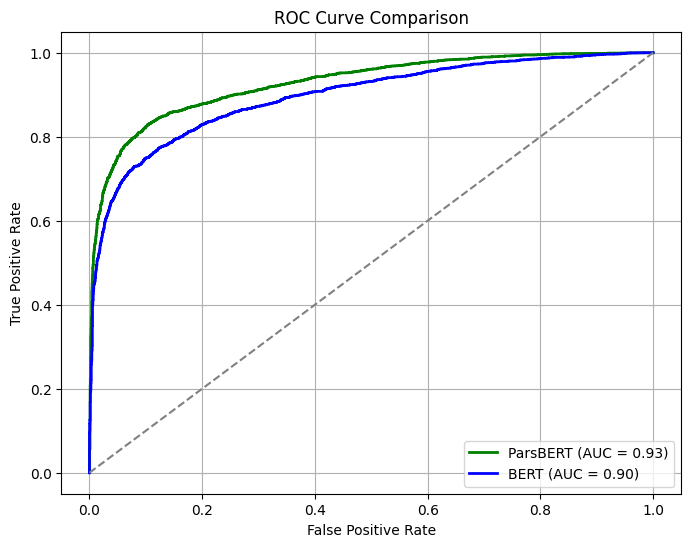

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax


preds_parsbert = trainer_parsbert.predict(tokenized_datasets_parsbert["validation"])
preds_bert = trainer_bert.predict(tokenized_datasets_bert["validation"])


y_true_parsbert = preds_parsbert.label_ids
y_score_parsbert = softmax(preds_parsbert.predictions, axis=1)[:, 1]

y_true_bert = preds_bert.label_ids
y_score_bert = softmax(preds_bert.predictions, axis=1)[:, 1]


fpr_parsbert, tpr_parsbert, _ = roc_curve(y_true_parsbert, y_score_parsbert)
roc_auc_parsbert = auc(fpr_parsbert, tpr_parsbert)

fpr_bert, tpr_bert, _ = roc_curve(y_true_bert, y_score_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)

plt.figure(figsize=(8, 6))
plt.plot(fpr_parsbert, tpr_parsbert, label=f'ParsBERT (AUC = {roc_auc_parsbert:.2f})', color='green', linewidth=2)
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##E) Testing

### 🔶 Now
- download the following dataset
- load it and use it as test dataset. Plot ROC curve for it.
- compare this with previouse results on snapfood dataset.

In [23]:
!wget https://github.com/Arminkhayati/Digikala-comments-sentiment-analysis/raw/main/data.xls

--2025-07-05 17:09:08--  https://github.com/Arminkhayati/Digikala-comments-sentiment-analysis/raw/main/data.xls
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Arminkhayati/Digikala-comments-sentiment-analysis/main/data.xls [following]
--2025-07-05 17:09:09--  https://raw.githubusercontent.com/Arminkhayati/Digikala-comments-sentiment-analysis/main/data.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61496832 (59M) [application/octet-stream]
Saving to: ‘data.xls’

data.xls            100%[===================>]  58.65M   290MB/s    in 0.2s    

2025-07-05 17:09:13 (290 MB/s) - ‘data.xls’ s

In [ ]:
from sklearn.model_selection import train_test_split

# Load the Digikala dataset from the .xls file
df_digi = pd.read_excel('data.xls')

print("--- Initial Digikala Data Info ---")
df_digi.info()

df_digi['full_comment'] = df_digi['title'].fillna('') + ' ' + df_digi['comment'].fillna('')

df_digi_filtered = df_digi[df_digi['recommend'].isin(['recommended', 'not recommended'])].copy()

df_digi_filtered['label'] = df_digi_filtered['recommend'].map({'recommended': 1, 'not recommended': 0})


df_digi_clean = df_digi_filtered[['full_comment', 'label']].copy()
df_digi_clean.rename(columns={'full_comment': 'comment'}, inplace=True)
df_digi_clean = df_digi_clean[df_digi_clean['comment'].str.strip() != ''].dropna()

print("\n--- Label distribution in the full cleaned dataset ---")
print(df_digi_clean['label'].value_counts())


_, df_digi_test = train_test_split(
    df_digi_clean,
    test_size=0.2,   
    random_state=42,
    stratify=df_digi_clean['label'] 
)

print("\n--- Label distribution in the FINAL STRATIFIED test set (should have both 0 and 1) ---")
print(df_digi_test['label'].value_counts())


digi_test_dataset = Dataset.from_pandas(df_digi_test)

print("\n--- Final Digikala Hugging Face Dataset ---")
print(digi_test_dataset)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
--- Initial Digikala Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   65535 non-null  int64  
 1   product_id           65535 non-null  int64  
 2   product_title        65535 non-null  object 
 3   title_en             65535 non-null  object 
 4   user_id              65535 non-null  int64  
 5   likes                65535 non-null  int64  
 6   dislikes             65535 non-null  int64  
 7   verification_status  65535 non-null  object 
 8   recommend            65535 non-null  object 
 9   title                63040 non-null  object 
 10  comment              65434 non-null  object 
 11  label                65472 non-null  float64
 12  advantages           26893 non-null  object 
 13  disadvantages        21705 n

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
--- First 5 Rows of the Digikala Dataset ---


,id,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,label,advantages,disadvantages
0,51316,197347,پوشک مای بیبی مدل Chamomile سایز 4 بسته 34 عددی,BC,3189366,8,9,verified,\N,پس میده متاسفانه,من چون همیشه مولفیکس استفاده کردم و هیچوقت مشک...,2.0,NaN,NaN
1,51330,481644,استند لوازم آرایشی کارا کد 12085,PC,4825894,1,1,verified,not_recommended,اصلا خوب نبود.,اصلا خوب نبود قطعاتش داخله سوراخایی که بود جا ...,2.0,NaN,NaN
2,51333,262958,کرم ضد جوش رنگی نوروا سری Actipur مدل Light Ti...,PC,4815343,9,1,verified,\N,کرم اکتی پور نوروا,من پوستم چربه و مستعد جوش،هر کرم پودری که استف...,2.0,"[""مناسب استفاده روزانه برای افراد چرب و مستعد ...","[""از نظر کیفیت ندارد اما با توجه به مقدار کمی ..."
3,51345,292365,چادر 2 نفره اف آی تی تنت مدل Single Roof AT1,TS,8089156,3,5,verified,recommended,خوبه میشه بهتر باشه,وقتی تحویل گرفتم از بزرگی بسته متعجب شدم اگر ب...,2.0,"[""زیبایی""]","[""نداشتن تهویه مناسب بزرگی بسته جمع شده""]"
4,51347,643764,مچ بند هوشمند شیائومی مدل Mi Band 3,PA,8097889,10,3,verified,\N,پیشنهاد میکنم خریداری کنید,قیمتش عالیه\nمن شنا گر هستم که 4 روز در هفته و...,2.0,NaN,"[""متاسفانه برچسب ضد خش خوبی ندارد""]"



--- Distribution of Recommendations (Counts) ---
recommend
\N                 24064
recommended        23672
not_recommended    10881
no_idea             6918
Name: count, dtype: int64

--- Distribution of Recommendations (Plot) ---


/tmp/ipython-input-31-410719390.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


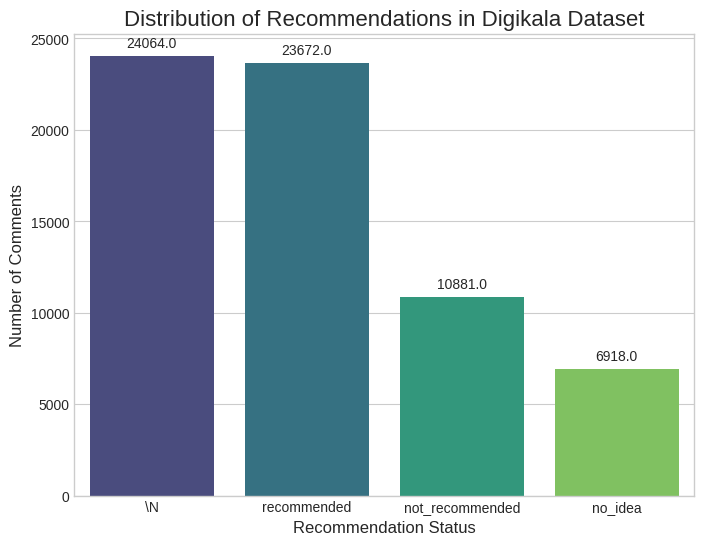

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_digi = pd.read_excel('data.xls')


print("--- First 5 Rows of the Digikala Dataset ---")
display(df_digi.head())


print("\n--- Distribution of Recommendations (Counts) ---")
recommend_counts = df_digi['recommend'].value_counts()
print(recommend_counts)


print("\n--- Distribution of Recommendations (Plot) ---")
plt.style.use('seaborn-v0_8-whitegrid') 
plt.figure(figsize=(8, 6))


ax = sns.countplot(
    x='recommend',
    data=df_digi,
    order=recommend_counts.index,  
    palette='viridis'
)


plt.title('Distribution of Recommendations in Digikala Dataset', fontsize=16)
plt.xlabel('Recommendation Status', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

df_digi = pd.read_excel('data.xls')

print("--- Filtering for 'recommended' and 'not_recommended' labels ---")
valid_labels = ['recommended', 'not_recommended']
df_filtered = df_digi[df_digi['recommend'].isin(valid_labels)].copy()

df_filtered['comment'] = df_filtered['title'].fillna('') + ' ' + df_filtered['comment'].fillna('')
df_filtered['label'] = df_filtered['recommend'].map({'recommended': 1, 'not_recommended': 0})

df_clean = df_filtered[['comment', 'label']].copy()
df_clean = df_clean[df_clean['comment'].str.strip() != ''].dropna()

print("\n--- Label distribution in the full, cleaned dataset before splitting ---")
print(df_clean['label'].value_counts())


_, df_digi_test = train_test_split(
    df_clean,
    test_size=0.20,
    random_state=42,
    stratify=df_clean['label']
)

print(f"\nCreated a test set with {len(df_digi_test)} samples (20% of cleaned data).")

print("\n--- Label distribution in the FINAL STRATIFIED test set ---")
print(df_digi_test['label'].value_counts())


digi_test_dataset = Dataset.from_pandas(df_digi_test)

print("\n--- Final Hugging Face Test Dataset Object ---")
print(digi_test_dataset)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
--- Filtering for 'recommended' and 'not_recommended' labels ---

--- Label distribution in the full, cleaned dataset before splitting ---
label
1    23670
0    10879
Name: count, dtype: int64

Created a test set with 6910 samples (20% of cleaned data).

--- Label distribution in the FINAL STRATIFIED test set ---
label
1    4734
0    2176
Name: count, dtype: int64

--- Final Hugging Face Test Dataset Object ---
Dataset({
    features: ['comment', 'label', '__index_level_0__'],
    num_rows: 6910
})



--- Evaluating ParsBERT on Digikala Test Set ---


Map:   0%|          | 0/6910 [00:00<?, ? examples/s]

Accuracy: 0.9313
F1 Score: 0.9311
AUC Score: 0.9759

--- Evaluating BERT-base-uncased on Digikala Test Set ---


Map:   0%|          | 0/6910 [00:00<?, ? examples/s]

Accuracy: 0.8059
F1 Score: 0.8122
AUC Score: 0.9055


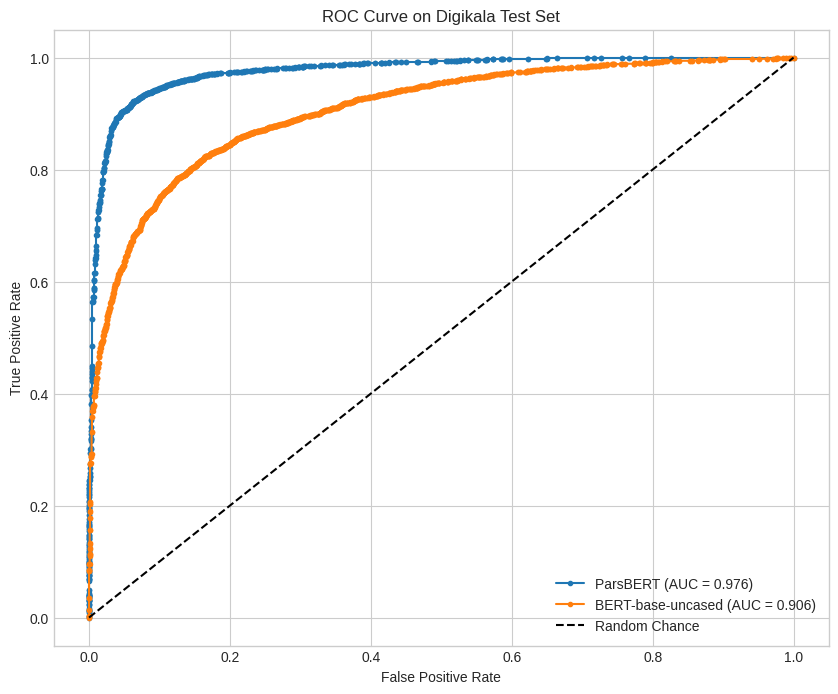

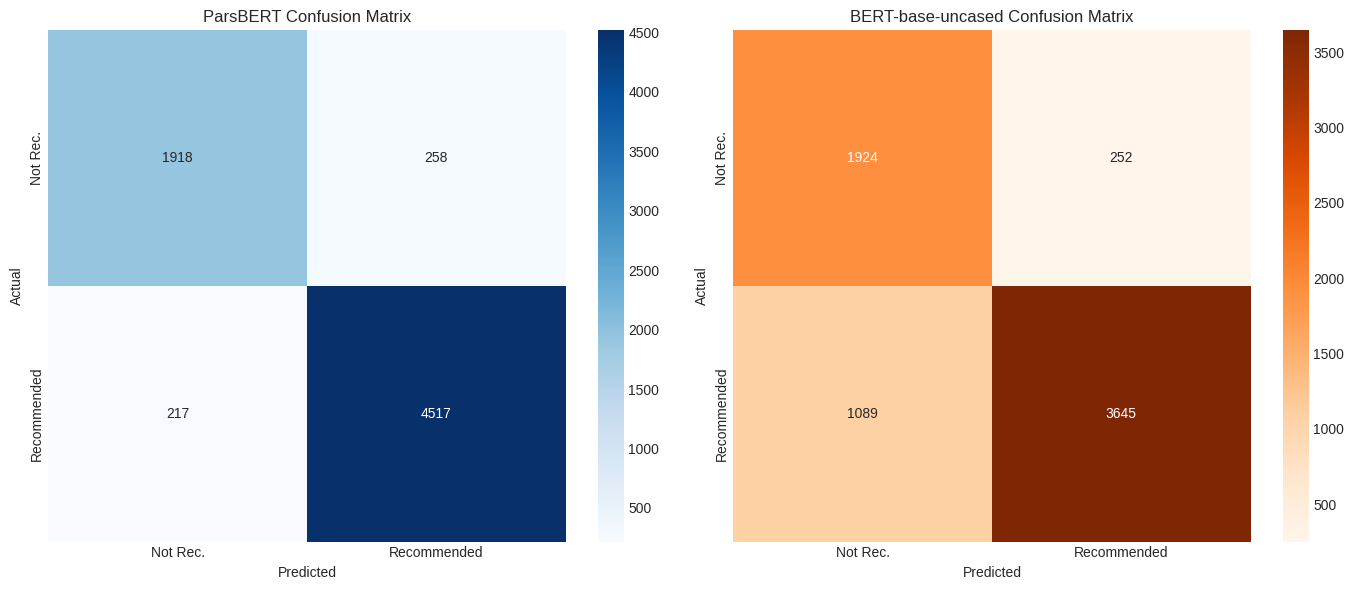

In [ ]:
def evaluate_on_test_set(trainer, tokenizer, test_dataset, model_label):
    """Evaluates a trained model on a test set and returns metrics for ROC plot."""
    print(f"\n--- Evaluating {model_label} on Digikala Test Set ---")

    tokenized_test_dataset = test_dataset.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=True
    )

    predictions = trainer.predict(tokenized_test_dataset)

    y_true = predictions.label_ids
    y_logits = predictions.predictions
    y_pred_class = np.argmax(y_logits, axis=-1)
    y_pred_probs = torch.softmax(torch.from_numpy(y_logits), dim=-1)[:, 1].numpy()

    accuracy = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class, average='weighted')
    auc = roc_auc_score(y_true, y_pred_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

    return fpr, tpr, auc, y_true, y_pred_class

fpr_p, tpr_p, auc_p, y_true_p, y_pred_p = evaluate_on_test_set(trainer_parsbert, parsbert_tokenizer, digi_test_dataset, "ParsBERT")

fpr_b, tpr_b, auc_b, y_true_b, y_pred_b = evaluate_on_test_set(trainer_bert, bert_tokenizer, digi_test_dataset, "BERT-base-uncased")

plt.figure(figsize=(10, 8))
plt.plot(fpr_p, tpr_p, marker='.', label=f'ParsBERT (AUC = {auc_p:.3f})')
plt.plot(fpr_b, tpr_b, marker='.', label=f'BERT-base-uncased (AUC = {auc_b:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Digikala Test Set')
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cm_p = confusion_matrix(y_true_p, y_pred_p)
sns.heatmap(cm_p, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Not Rec.', 'Recommended'], yticklabels=['Not Rec.', 'Recommended'])
axes[0].set_title('ParsBERT Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_b = confusion_matrix(y_true_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Oranges', ax=axes[1], xticklabels=['Not Rec.', 'Recommended'], yticklabels=['Not Rec.', 'Recommended'])
axes[1].set_title('BERT-base-uncased Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()